# Testing conditional valid metrics for locart

In [1]:
import numpy as np
import pandas as pd
import os

from nonconformist.cp import IcpRegressor
from nonconformist.nc import NcFactory
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

from lcv.locart import LocalRegressionSplit, LocartSplit, MondrianRegressionSplit, QuantileSplit
from lcv.locluster import KmeansSplit
from lcv.models import QuantileGradientBoosting, QuantileForest
from lcv.scores import RegressionScore, QuantileScore
import time


from lcv.locart import LocartSplit, MondrianRegressionSplit
from lcv.scores import RegressionScore
from lcv.simulation import simulation
from lcv.utils import compute_interval_length, HSIC_correlation, pearson_correlation, wsc_coverage, ILS_coverage, split

original_path = os.getcwd()

# figure path
images_dir = "figures"

## Testing metrics for simulated data:

Generating homoscedastic data just for testing:

In [2]:
random_seed = 1250
d = 20
coef = 2
kind = "homoscedastic"
n = 10000
sim_obj = simulation(dim = d, coef = coef)
sim_kind = getattr(sim_obj, kind)
sim_kind(n, random_seed = random_seed)
split_conformal = split(sim_obj.X, sim_obj.y, test_size = 0.5, calibrate = True)

Fitting locart to data and testing:

In [3]:
locart = LocartSplit(nc_score = RegressionScore, base_model = RandomForestRegressor, 
alpha = 0.1, split_calib = True)
locart.fit(split_conformal["X_train"], split_conformal["y_train"])
locart.calib(split_conformal["X_calib"], split_conformal["y_calib"])

# predictions
pred_locart = locart.predict(split_conformal["X_test"])

Fitting Mondrian to comparisson:

In [4]:
micp = MondrianRegressionSplit(RandomForestRegressor, alpha = 0.1, k = 10)
micp.fit(split_conformal["X_train"], split_conformal["y_train"])
micp.calibrate(split_conformal["X_test"], split_conformal["y_test"])

# predictions
pred_micp = micp.predict(split_conformal["X_test"])

Testing firstly for homoscedastic data:

### Homoscedastic data

Correlation:

In [5]:
# testing both correlations
pc_locart = pearson_correlation(pred_locart, split_conformal["y_test"])
hsic_locart = HSIC_correlation(pred_locart, split_conformal["y_test"])
print("Pearson correlation: {} \n HSIC correlation: {}".format(pc_locart, hsic_locart))

Pearson correlation: -0.003156230005196689 
 HSIC correlation: 9.543091031167827e-10


In [6]:
# testing for mondrian
pc_micp = pearson_correlation(pred_micp, split_conformal["y_test"])
hsic_micp = HSIC_correlation(pred_micp, split_conformal["y_test"])
print("Pearson correlation: {} \n HSIC correlation: {}".format(pc_micp, hsic_micp))

Pearson correlation: 0.023968710361934605 
 HSIC correlation: 1.2051528701519785e-06


Worst slab coverage:

In [6]:
wsc_locart = wsc_coverage(split_conformal["X_test"], split_conformal["y_test"], pred_locart)
print("Delta wsc: {}".format(wsc_locart))

Delta wsc: 0.0012422535211267238


In [7]:
wsc_micp = wsc_coverage(split_conformal["X_test"], split_conformal["y_test"], pred_micp)
print("Delta wsc: {}".format(wsc_micp))

Delta wsc: 0.0026422535211267917


ILS coverage:

In [5]:
ils_locart_micp = ILS_coverage(pred_locart, pred_micp, split_conformal["y_test"])
print("ILS coverage: {}".format(ils_locart_micp))

ILS coverage: -0.020822222222222297


### Heteroscedastic data

In [33]:
random_seed = 1250
d = 20
coef = 2
kind = "heteroscedastic"
n = 10000
sim_obj = simulation(dim = d, coef = coef, hetero_value = 0.25)
sim_kind = getattr(sim_obj, kind)
sim_kind(n, random_seed = random_seed)
split_conformal = split(sim_obj.X, sim_obj.y, test_size = 0.5, calibrate = True)

fitting models:

In [34]:
locart = LocartSplit(nc_score = RegressionScore, base_model = RandomForestRegressor, 
alpha = 0.1, split_calib = True)
locart.fit(split_conformal["X_train"], split_conformal["y_train"])
locart.calib(split_conformal["X_calib"], split_conformal["y_calib"])

# predictions
pred_locart = locart.predict(split_conformal["X_test"])

micp = MondrianRegressionSplit(RandomForestRegressor, alpha = 0.1, k = 10)
micp.fit(split_conformal["X_train"], split_conformal["y_train"])
micp.calibrate(split_conformal["X_test"], split_conformal["y_test"])

# predictions
pred_micp = micp.predict(split_conformal["X_test"])

Correlation:

In [35]:
pc_locart = pearson_correlation(pred_locart, split_conformal["y_test"])
hsic_locart = HSIC_correlation(pred_locart, split_conformal["y_test"])

pc_micp = pearson_correlation(pred_micp, split_conformal["y_test"])
hsic_micp = HSIC_correlation(pred_micp, split_conformal["y_test"])

print("Pearson correlation for locart: {} \n HSIC correlation for locart: {}".format(pc_locart, hsic_locart))
print("Pearson correlation for mondrian: {} \n HSIC correlation for mondrian: {}".format(pc_micp, hsic_micp))

Pearson correlation for locart: 0.004393116555865671 
 HSIC correlation for locart: 2.6730960642672893e-07
Pearson correlation for mondrian: 0.018724455998235096 
 HSIC correlation for mondrian: 5.40020467283947e-06


In [36]:
ils_locart_micp = ILS_coverage(pred_locart, pred_micp, split_conformal["y_test"])
print("ILS coverage: {}".format(ils_locart_micp))

ILS coverage: 0.03744606525911709


In [37]:
wsc_locart = wsc_coverage(split_conformal["X_test"], split_conformal["y_test"], pred_locart)
print("Delta wsc: {}".format(wsc_locart))

wsc_micp = wsc_coverage(split_conformal["X_test"], split_conformal["y_test"], pred_micp)
print("Delta wsc: {}".format(wsc_micp))

Delta wsc: 0.012092447129909423
Delta wsc: 0.0004568578553616476


### Asymmetric data

In [28]:
random_seed = 1250
d = 20
coef = 2
kind = "asymmetric"
asym_value = 0.6
n = 10000
sim_obj = simulation(dim = d, coef = coef, asym_value= asym_value)
sim_kind = getattr(sim_obj, kind)
sim_kind(n, random_seed = random_seed)
split_conformal = split(sim_obj.X, sim_obj.y, test_size = 0.5, calibrate = True)

fitting models:

In [29]:
locart = LocartSplit(nc_score = RegressionScore, base_model = RandomForestRegressor, 
alpha = 0.1, split_calib = True)
locart.fit(split_conformal["X_train"], split_conformal["y_train"])
locart.calib(split_conformal["X_calib"], split_conformal["y_calib"])

# predictions
pred_locart = locart.predict(split_conformal["X_test"])

micp = MondrianRegressionSplit(RandomForestRegressor, alpha = 0.1, k = 10)
micp.fit(split_conformal["X_train"], split_conformal["y_train"])
micp.calibrate(split_conformal["X_test"], split_conformal["y_test"])

# predictions
pred_micp = micp.predict(split_conformal["X_test"])

Metrics:

In [30]:
pc_locart = pearson_correlation(pred_locart, split_conformal["y_test"])
hsic_locart = HSIC_correlation(pred_locart, split_conformal["y_test"])

pc_micp = pearson_correlation(pred_micp, split_conformal["y_test"])
hsic_micp = HSIC_correlation(pred_micp, split_conformal["y_test"])

print("Pearson correlation for locart: {} \n HSIC correlation for locart: {}".format(pc_locart, hsic_locart))
print("Pearson correlation for mondrian: {} \n HSIC correlation for mondrian: {}".format(pc_micp, hsic_micp))

Pearson correlation for locart: 0.004768642314300733 
 HSIC correlation for locart: 1.1279158363082266e-08
Pearson correlation for mondrian: 0.011931114803949651 
 HSIC correlation for mondrian: 4.508715588638028e-06


In [31]:
ils_locart_micp = ILS_coverage(pred_locart, pred_micp, split_conformal["y_test"])
print("ILS coverage: {}".format(ils_locart_micp))

ILS coverage: 0.04042151394422311


In [32]:
wsc_locart = wsc_coverage(split_conformal["X_test"], split_conformal["y_test"], pred_locart)
print("Delta wsc: {}".format(wsc_locart))

wsc_micp = wsc_coverage(split_conformal["X_test"], split_conformal["y_test"], pred_micp)
print("Delta wsc: {}".format(wsc_micp))

Delta wsc: 0.030753233830845716
Delta wsc: 0.007800000000000029


### More asymmetric

In [38]:
random_seed = 1250
d = 20
coef = 2
kind = "asymmetric"
asym_value = 1.5
n = 10000
sim_obj = simulation(dim = d, coef = coef, asym_value= asym_value)
sim_kind = getattr(sim_obj, kind)
sim_kind(n, random_seed = random_seed)
split_conformal = split(sim_obj.X, sim_obj.y, test_size = 0.5, calibrate = True)

fitting models:

In [40]:
locart = LocartSplit(nc_score = RegressionScore, base_model = RandomForestRegressor, 
alpha = 0.1, split_calib = True)
locart.fit(split_conformal["X_train"], split_conformal["y_train"])
locart.calib(split_conformal["X_calib"], split_conformal["y_calib"])

# predictions
pred_locart = locart.predict(split_conformal["X_test"])

micp = MondrianRegressionSplit(RandomForestRegressor, alpha = 0.1, k = 10)
micp.fit(split_conformal["X_train"], split_conformal["y_train"])
micp.calibrate(split_conformal["X_test"], split_conformal["y_test"])

# predictions
pred_micp = micp.predict(split_conformal["X_test"])

Metrics:

In [41]:
pc_locart = pearson_correlation(pred_locart, split_conformal["y_test"])
hsic_locart = HSIC_correlation(pred_locart, split_conformal["y_test"])

pc_micp = pearson_correlation(pred_micp, split_conformal["y_test"])
hsic_micp = HSIC_correlation(pred_micp, split_conformal["y_test"])

print("Pearson correlation for locart: {} \n HSIC correlation for locart: {}".format(pc_locart, hsic_locart))
print("Pearson correlation for mondrian: {} \n HSIC correlation for mondrian: {}".format(pc_micp, hsic_micp))

Pearson correlation for locart: 0.010153643386167801 
 HSIC correlation for locart: 2.88854195812755e-06
Pearson correlation for mondrian: -8.723385916835798e-06 
 HSIC correlation for mondrian: 4.072958723393719e-06


In [42]:
ils_locart_micp = ILS_coverage(pred_locart, pred_micp, split_conformal["y_test"])
print("ILS coverage: {}".format(ils_locart_micp))

ILS coverage: 0.0697280632411067


In [43]:
wsc_locart = wsc_coverage(split_conformal["X_test"], split_conformal["y_test"], pred_locart)
print("Delta wsc: {}".format(wsc_locart))

wsc_micp = wsc_coverage(split_conformal["X_test"], split_conformal["y_test"], pred_micp)
print("Delta wsc: {}".format(wsc_micp))

Delta wsc: 0.001724050632911367
Delta wsc: 0.022047852760736175


### Non-corr heteroscedastic

In [44]:
random_seed = 1250
d = 20
coef = 2
kind = "non_cor_heteroscedastic"
hetero_value = 0.25
n = 10000
sim_obj = simulation(dim = d, coef = coef, hetero_value=hetero_value)
sim_kind = getattr(sim_obj, kind)
sim_kind(n, random_seed = random_seed)
split_conformal = split(sim_obj.X, sim_obj.y, test_size = 0.5, calibrate = True)

fitting models:

In [45]:
locart = LocartSplit(nc_score = RegressionScore, base_model = RandomForestRegressor, 
alpha = 0.1, split_calib = True)
locart.fit(split_conformal["X_train"], split_conformal["y_train"])
locart.calib(split_conformal["X_calib"], split_conformal["y_calib"])

# predictions
pred_locart = locart.predict(split_conformal["X_test"])

micp = MondrianRegressionSplit(RandomForestRegressor, alpha = 0.1, k = 10)
micp.fit(split_conformal["X_train"], split_conformal["y_train"])
micp.calibrate(split_conformal["X_test"], split_conformal["y_test"])

# predictions
pred_micp = micp.predict(split_conformal["X_test"])

Metrics:

In [46]:
pc_locart = pearson_correlation(pred_locart, split_conformal["y_test"])
hsic_locart = HSIC_correlation(pred_locart, split_conformal["y_test"])

pc_micp = pearson_correlation(pred_micp, split_conformal["y_test"])
hsic_micp = HSIC_correlation(pred_micp, split_conformal["y_test"])

print("Pearson correlation for locart: {} \n HSIC correlation for locart: {}".format(pc_locart, hsic_locart))
print("Pearson correlation for mondrian: {} \n HSIC correlation for mondrian: {}".format(pc_micp, hsic_micp))

Pearson correlation for locart: 0.020396862021520204 
 HSIC correlation for locart: 5.7421433532560255e-06
Pearson correlation for mondrian: 0.02689440646500909 
 HSIC correlation for mondrian: 8.639612502657903e-06


In [47]:
ils_locart_micp = ILS_coverage(pred_locart, pred_micp, split_conformal["y_test"])
print("ILS coverage: {}".format(ils_locart_micp))

ILS coverage: -0.03618446601941738


In [48]:
wsc_locart = wsc_coverage(split_conformal["X_test"], split_conformal["y_test"], pred_locart)
print("Delta wsc: {}".format(wsc_locart))

wsc_micp = wsc_coverage(split_conformal["X_test"], split_conformal["y_test"], pred_micp)
print("Delta wsc: {}".format(wsc_micp))

Delta wsc: 0.015239702233250663
Delta wsc: 0.008424277456647422


## Testing metrics for real data:

Testing main regression splits in some real data:

In [3]:
def obtain_main_metrics(data_name,
type_score = "regression",
base_model = RandomForestRegressor,
figname_tree = "locart_tree_real_data.pdf",
test_size = 0.4, 
calib_size = 0.5,
random_seed = 1250, 
sig = 0.05,
split_calib = True,
plot_tree = True,
n_estimators = 200,
quantiles = [0.8, 0.85, 0.9, 0.95],
random_states = [750, 85, 666, 69],
prop_k = np.arange(2, 11),
tune_k = True,
nbins = 20,
criterion = "squared_error",
max_depth = None,
max_leaf_nodes = None,
min_samples_leaf = 300,
prune = True,
**kwargs):
    # importing data, selecting some rows and then splitting
    data_path = os.path.normpath(os.getcwd() + os.sep + os.pardir) + "/data/processed/" + data_name + ".csv"

    # reading data using pandas
    data = pd.read_csv(data_path)
    y = data["target"].to_numpy()
    X = (data.
    drop("target", axis = 1).
    to_numpy())

    # splitting data into train, calibration and test
    data = split(X, y, test_size, calib_size, calibrate = True, random_seed = random_seed)
    # setting seed
    np.random.seed(random_seed)

    if type_score == "regression":
        # fitting mondrian regression split
        print("Fitting mondrian regression split")
        start_mondrian_split = time.time()
        micp = MondrianRegressionSplit(base_model, alpha = sig, k = nbins, **kwargs)
        micp.fit(data["X_train"], data["y_train"])
        micp.calibrate(data["X_calib"], data["y_calib"])

        end_mondrian_split = time.time() - start_mondrian_split
        print("Time Elapsed to fit mondrian regression split: ", end_mondrian_split)

        print("Computing metrics")
        start_mondrian_split = time.time()
        # predictions
        micp_pred = micp.predict(data["X_test"])

        # mondrian icp correlations 
        micp_pcor = pearson_correlation(micp_pred, data["y_test"])
        micp_hsic = HSIC_correlation(micp_pred, data["y_test"])

        # mondrian wsc
        micp_wsc = wsc_coverage(data["X_test"], data["y_test"], micp_pred)

        # mean interval length
        micp_interval_len = np.mean(compute_interval_length(micp_pred))


        # marginal coverage
        marg_cover = np.logical_and(data["y_test"] >= micp_pred[:, 0], 
            data["y_test"] <= micp_pred[:, 1]) + 0
        micp_ave_marginal_cov = np.mean(
            marg_cover
        )

        # interval length | coveraqe
        cover_idx = np.where(marg_cover == 1)
        micp_interval_len_cover = np.mean(compute_interval_length(micp_pred[cover_idx]))


        end_mondrian_split = time.time() - start_mondrian_split
        print("Time Elapsed to compute statistics for mondrian regression split: ", end_mondrian_split)

        print("Fitting locluster")
        start_locluster = time.time()
        locluster_obj = KmeansSplit(nc_score = RegressionScore, base_model = base_model, alpha = sig, **kwargs)
        locluster_obj.fit(data["X_train"], data["y_train"])
        locluster_obj.calib(data["X_calib"], data["y_calib"], tune_k = tune_k, 
        prop_k = prop_k, n_estimators = n_estimators, quantiles = quantiles, random_states = random_states)

        end_locluster = time.time() - start_locluster
        print("Time Elapsed to fit locluster: ", end_locluster)


        print("Computing metrics")
        start_locluster = time.time()
        # predictions
        locluster_pred = np.array(locluster_obj.predict(data["X_test"], length = 2000))

        # mondrian icp correlations 
        locluster_pcor = pearson_correlation(locluster_pred, data["y_test"])
        locluster_hsic = HSIC_correlation(locluster_pred, data["y_test"])

        # mondrian wsc
        locluster_wsc = wsc_coverage(data["X_test"], data["y_test"], locluster_pred)

        # mean interval length
        locluster_interval_len = np.mean(compute_interval_length(locluster_pred))

        # marginal coverage
        marg_cover = np.logical_and(data["y_test"] >= locluster_pred[:, 0], 
            data["y_test"] <= locluster_pred[:, 1]) + 0
        locluster_ave_marginal_cov = np.mean(
            marg_cover
        )

        # interval length | coveraqe
        cover_idx = np.where(marg_cover == 1)
        locluster_interval_len_cover = np.mean(compute_interval_length(locluster_pred[cover_idx]))

        end_locluster = time.time() - start_locluster
        print("Time Elapsed to compute metrics for Locluster: ", end_locluster)


        print("Fitting locart")
        start_loc = time.time()
        # fitting locart
        locart_obj = LocartSplit(nc_score = RegressionScore, base_model = base_model, alpha = sig, split_calib = split_calib, **kwargs)
        locart_obj.fit(data["X_train"], data["y_train"])
        locart_obj.calib(data["X_calib"], data["y_calib"], max_depth = max_depth, 
        max_leaf_nodes = max_leaf_nodes, min_samples_leaf = min_samples_leaf, criterion = criterion, prune_tree = prune)
        
        end_loc = time.time() - start_loc
        print("Time Elapsed to fit Locart: ", end_loc)

        print("Computing metrics")
        start_loc = time.time()
       # predictions
        locart_pred = np.array(locart_obj.predict(data["X_test"], length = 2000))

        # mondrian icp correlations 
        locart_pcor = pearson_correlation(locart_pred, data["y_test"])
        locart_hsic = HSIC_correlation(locart_pred, data["y_test"])

        # mondrian wsc
        locart_wsc = wsc_coverage(data["X_test"], data["y_test"], locart_pred)

        # mean interval length
        locart_interval_len = np.mean(compute_interval_length(locart_pred))

        # marginal coverage
        marg_cover = np.logical_and(data["y_test"] >= locart_pred[:, 0], 
            data["y_test"] <= locart_pred[:, 1]) + 0
        locart_ave_marginal_cov = np.mean(
            marg_cover
        )

        # interval length | coveraqe
        cover_idx = np.where(marg_cover == 1)
        locart_interval_len_cover = np.mean(compute_interval_length(locart_pred[cover_idx]))
        end_loc = time.time() - start_loc
        print("Time Elapsed to compute metrics for Locart: ", end_loc)

        # fitting default regression split
        print("Fitting regression split")
        start_split = time.time()
        model = base_model(**kwargs)
        nc = NcFactory.create_nc(model)
        icp = IcpRegressor(nc)
        icp.fit(data["X_train"], data["y_train"])
        icp.calibrate(data["X_calib"], data["y_calib"])

        end_split = time.time() - start_split
        print("Time Elapsed to fit regression split: ", end_split)

        print("Computing metrics")
        start_split = time.time()
        # predictions
        icp_pred = icp.predict(data["X_test"], significance = sig)

        # ICP icp correlations 
        icp_pcor = pearson_correlation(icp_pred, data["y_test"])
        icp_hsic = HSIC_correlation(icp_pred, data["y_test"])

        # ICP wsc
        icp_wsc = wsc_coverage(data["X_test"], data["y_test"], icp_pred)

        # ICP interval length
        icp_interval_len = np.mean(compute_interval_length(icp_pred))

       # marginal coverage
        marg_cover = np.logical_and(data["y_test"] >= icp_pred[:, 0], 
            data["y_test"] <= icp_pred[:, 1]) + 0
        icp_ave_marginal_cov = np.mean(
            marg_cover
        )

        # interval length | coveraqe
        cover_idx = np.where(marg_cover == 1)
        icp_interval_len_cover = np.mean(compute_interval_length(icp_pred[cover_idx]))

        end_split = time.time() - start_split
        print("Time Elapsed to compute statistics for regression split: ", end_split)

        # fitting wighted regression split
        print("Fitting weighted regression split")
        start_weighted_split = time.time()
        wicp = LocalRegressionSplit(base_model, alpha = sig, **kwargs)
        wicp.fit(data["X_train"], data["y_train"])
        wicp.calibrate(data["X_test"], data["y_test"])

        end_weighted_split = time.time() - start_weighted_split
        print("Time Elapsed to fit weighted regression split: ", end_weighted_split)

        print("Computing metrics")
        start_weighted_split = time.time()
        # predictions
        wicp_pred = wicp.predict(data["X_test"])

        # ICP icp correlations 
        wicp_pcor = pearson_correlation(wicp_pred, data["y_test"])
        wicp_hsic = HSIC_correlation(wicp_pred, data["y_test"])

        # ICP wsc
        wicp_wsc = wsc_coverage(data["X_test"], data["y_test"], wicp_pred)

        # ICP interval length
        wicp_interval_len = np.mean(compute_interval_length(wicp_pred))

        # marginal coverage
        marg_cover = np.logical_and(data["y_test"] >= wicp_pred[:, 0], 
            data["y_test"] <= wicp_pred[:, 1]) + 0
        wicp_ave_marginal_cov = np.mean(
            marg_cover
        )

        # interval length | coveraqe
        cover_idx = np.where(marg_cover == 1)
        wicp_interval_len_cover = np.mean(compute_interval_length(wicp_pred[cover_idx]))
        print("Time Elapsed to compute statistics for weighted regression split: ", end_weighted_split)

        # computing ils coverage of all methods compared to locart
        ils_locart_micp = ILS_coverage(locart_pred, micp_pred, data["y_test"])
        ils_locart_wicp = ILS_coverage(locart_pred, wicp_pred, data["y_test"])
        ils_locart_icp = ILS_coverage(locart_pred, icp_pred, data["y_test"])
        ils_locart_locluster = ILS_coverage(locart_pred, locluster_pred, data["y_test"])

        
        all_results =  pd.DataFrame(data = {"Methods":["LOCLUSTER", "LOCART", "Regresion split", "Weighted regression split", "Mondrian regression split"],
        "Pearson correlation":[locluster_pcor, locart_pcor,  icp_pcor, wicp_pcor, micp_pcor],
        "HSIC correlation":[locluster_hsic, locart_hsic, icp_hsic, wicp_hsic, micp_hsic],
        "delta wsc":[locluster_wsc, locart_wsc, icp_wsc, wicp_wsc, micp_wsc],
        "delta_ils":[ils_locart_locluster, 0, ils_locart_icp, ils_locart_wicp, ils_locart_micp],
        "Average marginal coverage":[locluster_ave_marginal_cov, locart_ave_marginal_cov, icp_ave_marginal_cov, wicp_ave_marginal_cov, micp_ave_marginal_cov],
        "Average interval length":[locluster_interval_len, locart_interval_len, icp_interval_len, wicp_interval_len, micp_interval_len],
        "Average interval length given coverage":[locluster_interval_len_cover, locart_interval_len_cover, icp_interval_len_cover,
        wicp_interval_len_cover, micp_interval_len_cover]})
    
    elif type_score == "quantile":
        # fitting gradient boosting quantile regression
        # first fitting quantile split
        print("Fitting CQR")
        cqr = QuantileSplit(base_model, alpha = sig, **kwargs)
        cqr.fit(data["X_train"], data["y_train"])
        cqr.calibrate(data["X_test"], data["y_test"])
        
        # icp real coverage and interval length
        pred_cqr = cqr.predict(X_test)
        cqr_cond_r_real = real_coverage(pred_cqr, y_mat)
        cqr_interval_len = compute_interval_length(pred_cqr)

        # computing icp measures
        cqr_ave_dist = np.mean(np.abs(cqr_cond_r_real - (1 - sig)))
        cqr_ave_marginal_cov = np.mean(cqr_cond_r_real)
        cqr_med_cover = np.median(cqr_cond_r_real)
        cqr_med_dist = np.median(np.abs(cqr_cond_r_real - (1 - sig)))
        cqr_interval = np.mean(cqr_interval_len)

        # fitting locluster
        print("Fitting Locluster")
        locluster_obj = KmeansSplit(nc_score = QuantileScore, base_model = base_model, alpha = sig, **kwargs)
        locluster_obj.fit(data["X_train"], data["y_train"])
        locluster_obj.calib(data["X_test"], data["y_test"], tune_k = tune_k, 
        prop_k = prop_k, n_estimators = n_estimators, quantiles = quantiles, random_states = random_states)


        # conditional coverage and interval length
        pred_locluster = np.array(locluster_obj.predict(X_test, length = 2000))
        cond_locluster_real =  real_coverage(pred_locluster, y_mat)
        locluster_interval_len = compute_interval_length(pred_locluster)

        # several measures
        locluster_ave_dist = np.mean(np.abs(cond_locluster_real - (1 - sig)))
        locluster_med_cover = np.median(cond_locluster_real)
        locluster_med_dist = np.median(np.abs(cond_locluster_real - (1 - sig)))
        locluster_ave_marginal_cov = np.mean(cond_locluster_real)
        locluster_interval = np.mean(locluster_interval_len)


        # fitting locart
        print("Fitting Locart")
        model = base_model(**kwargs)
        locart_obj = LocartSplit(nc_score = QuantileScore, base_model = base_model,
        base_model_type=True, alpha = sig, split_calib = split_calib, **kwargs)
        locart_obj.fit(data["X_train"], data["y_train"])
        locart_obj.calib(data["X_test"], data["y_test"], max_depth = max_depth, 
        max_leaf_nodes = max_leaf_nodes, min_samples_leaf = min_samples_leaf, criterion = criterion)

        # conditional coverage and interval length
        pred_locart = locart_obj.predict(X_test, length=2000)
        cond_locart_real = real_coverage(pred_locart, y_mat)
        locart_interval_len = compute_interval_length(pred_locart)
        
        # several measures
        locart_ave_dist = np.mean(np.abs(cond_locart_real - (1 - sig)))
        locart_med_cover = np.median(cond_locart_real)
        locart_med_dist = np.median(np.abs(cond_locart_real - (1 - sig)))
        locart_ave_marginal_cov = np.mean(cond_locart_real)
        locart_interval = np.mean(locart_interval_len)

        # fitting euclidean binning
        locart_obj.uniform_binning(data["X_test"], data["y_test"])

        # computing local coverage to uniform binning
        pred_uniform = locart_obj.predict(
            X_test, length=2000, type_model="euclidean"
        )

        uniform_cond_r_real = real_coverage(pred_uniform, y_mat)
        uniform_interval_len = compute_interval_length(pred_uniform)

        # computing euclidean binning measures
        uniform_ave_dist = np.mean(np.abs(uniform_cond_r_real - (1 - sig)))
        uniform_ave_marginal_cov = np.mean(uniform_cond_r_real)
        uniform_med_cover = np.median(uniform_cond_r_real)
        uniform_med_dist = np.median(np.abs(uniform_cond_r_real - (1 - sig)))
        uniform_interval = np.mean(uniform_interval_len)

        # fitting raw quantilic regression
        qgb_obj = model
        qgb_obj.fit(data["X_train"], data["y_train"])

        pred_qgb = qgb_obj.predict(X_test)
        cond_qgb_real = real_coverage(pred_qgb, y_mat)
        qgb_interval_len = compute_interval_length(pred_qgb)

        # computing raw quantilic measures
        qgb_ave_dist = np.mean(np.abs(cond_qgb_real - (1 - sig)))
        qgb_ave_marginal_cov = np.mean(cond_qgb_real)
        qgb_med_cover = np.median(cond_qgb_real)
        qgb_med_dist = np.median(np.abs(cond_qgb_real - (1 - sig)))
        qgb_interval = np.mean(qgb_interval_len)
    
        
        all_results =  pd.DataFrame(data = {"Methods":["LOCLUSTER", "LOCART", "CQR", "Euclidean CQR", "Quantilic Regression"],
        "Average distance":[locluster_ave_dist, locart_ave_dist, cqr_ave_dist, uniform_ave_dist, qgb_ave_dist],
        "Median conditional coverage":[locluster_med_cover, locart_med_cover, cqr_med_cover, uniform_med_cover, qgb_med_cover],
        "Median distance":[locluster_med_dist, locart_med_dist, cqr_med_dist, uniform_med_dist, qgb_med_dist],
        "Average marginal coverage":[locluster_ave_marginal_cov, locart_ave_marginal_cov, cqr_ave_marginal_cov, uniform_ave_marginal_cov, qgb_ave_marginal_cov],
        "Average interval length":[locluster_interval, locart_interval, cqr_interval, uniform_interval, qgb_interval]})

        # plotting boxplots
        # gathering all data into a data frame
        boxplot_data = pd.melt(pd.DataFrame(data = {"Methods":list(np.repeat(["LOCLUSTER", "LOCART", "CQR", 
        "Euclidean CQR", "Quantilic Regression"],
        locart_interval_len.shape[0])),
        "Interval length": list(np.concatenate((locluster_interval_len, locart_interval_len, cqr_interval_len, uniform_interval_len, qgb_interval_len))),
        "Coverage": list(np.concatenate((cond_locluster_real, cond_locart_real, cqr_cond_r_real, uniform_cond_r_real, cond_qgb_real)))
        }), id_vars = ['Methods'], value_vars = ['Interval length', 'Coverage'])

        plt.figure(figsize=(10, 6))
        sns.catplot(data = boxplot_data,
        y = 'Methods', x = 'value', col = 'variable', kind = 'box', sharex= False)
        plt.tight_layout()
        plt.show()
        
    # plotting tree to visualize partitions
    if plot_tree:
        plt.figure(figsize=(25, 20))
        locart_obj.plot_locart()
        plt.savefig(f"{images_dir}/{figname_tree}")
        plt.show()
    
    return [all_results, locart_obj]

Testing for red wine data with locart splitting calibration:

Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  0.4024190902709961
Computing metrics
Time Elapsed to compute statistics for mondrian regression split:  2.499328851699829
Fitting locluster
Time Elapsed to fit locluster:  3.087170362472534
Computing metrics
Time Elapsed to compute metrics for Locluster:  6.871399641036987
Fitting locart
Time Elapsed to fit Locart:  0.347994327545166
Computing metrics
Time Elapsed to compute metrics for Locart:  7.46652626991272
Fitting regression split
Time Elapsed to fit regression split:  0.34998607635498047
Computing metrics


/home/kuben/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/kuben/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time Elapsed to compute statistics for regression split:  2.9309592247009277
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  0.5658271312713623
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  0.5658271312713623


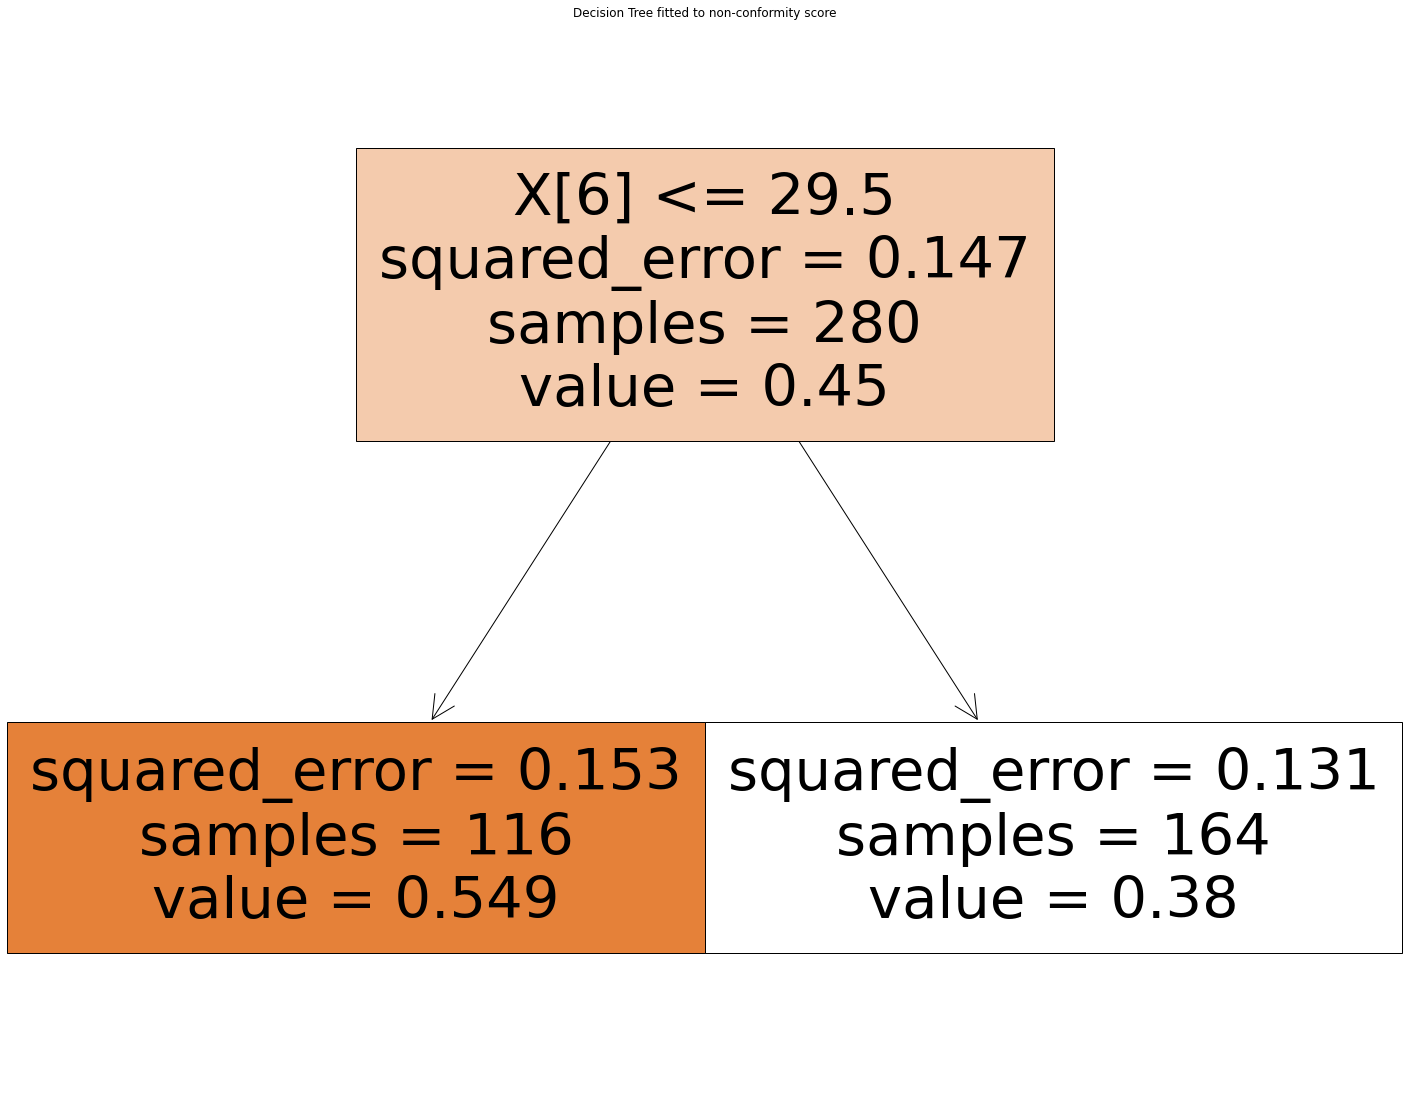

<Figure size 432x288 with 0 Axes>

In [5]:
values_winered = obtain_main_metrics(data_name = "winered",
test_size = 0.3,
calib_size = 0.5,
split_calib = True,
random_seed = 1250,
sig  = 0.1,
nbins = 10,
min_samples_leaf= 100,
figname_tree = "locart_tree_winered_split.pdf",
random_state = 750)

In [6]:
values_winered[0]

,Methods,Pearson correlation,HSIC correlation,delta wsc,delta_ils,Average marginal coverage,Average interval length,Average interval length given coverage
0,LOCLUSTER,-0.045741,3.493714e-06,0.016026,0.028066,0.908333,2.023167,2.020696
1,LOCART,0.047360,1.421517e-05,0.055357,0.000000,0.887500,2.014569,2.019574
2,Regresion split,NaN,-1.163372e-30,0.004327,0.003180,0.881250,1.840000,1.840000
3,Weighted regression split,0.053656,9.713661e-05,0.050000,0.083333,0.950000,2.116050,2.128257
4,Mondrian regression split,0.059947,1.429368e-04,0.034978,0.003533,0.877083,1.888550,1.899055


Testing for red wine without splitting in calibration:

Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  0.3716115951538086
Computing metrics
Time Elapsed to compute statistics for mondrian regression split:  2.854612112045288
Fitting locluster
Time Elapsed to fit locluster:  2.729067087173462
Computing metrics
Time Elapsed to compute metrics for Locluster:  10.559735298156738
Fitting locart
Time Elapsed to fit Locart:  0.41974592208862305
Computing metrics
Time Elapsed to compute metrics for Locart:  8.419057369232178
Fitting regression split
Time Elapsed to fit regression split:  0.40769195556640625
Computing metrics


/home/kuben/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/kuben/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time Elapsed to compute statistics for regression split:  3.2948853969573975
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  0.6650395393371582
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  0.6650395393371582


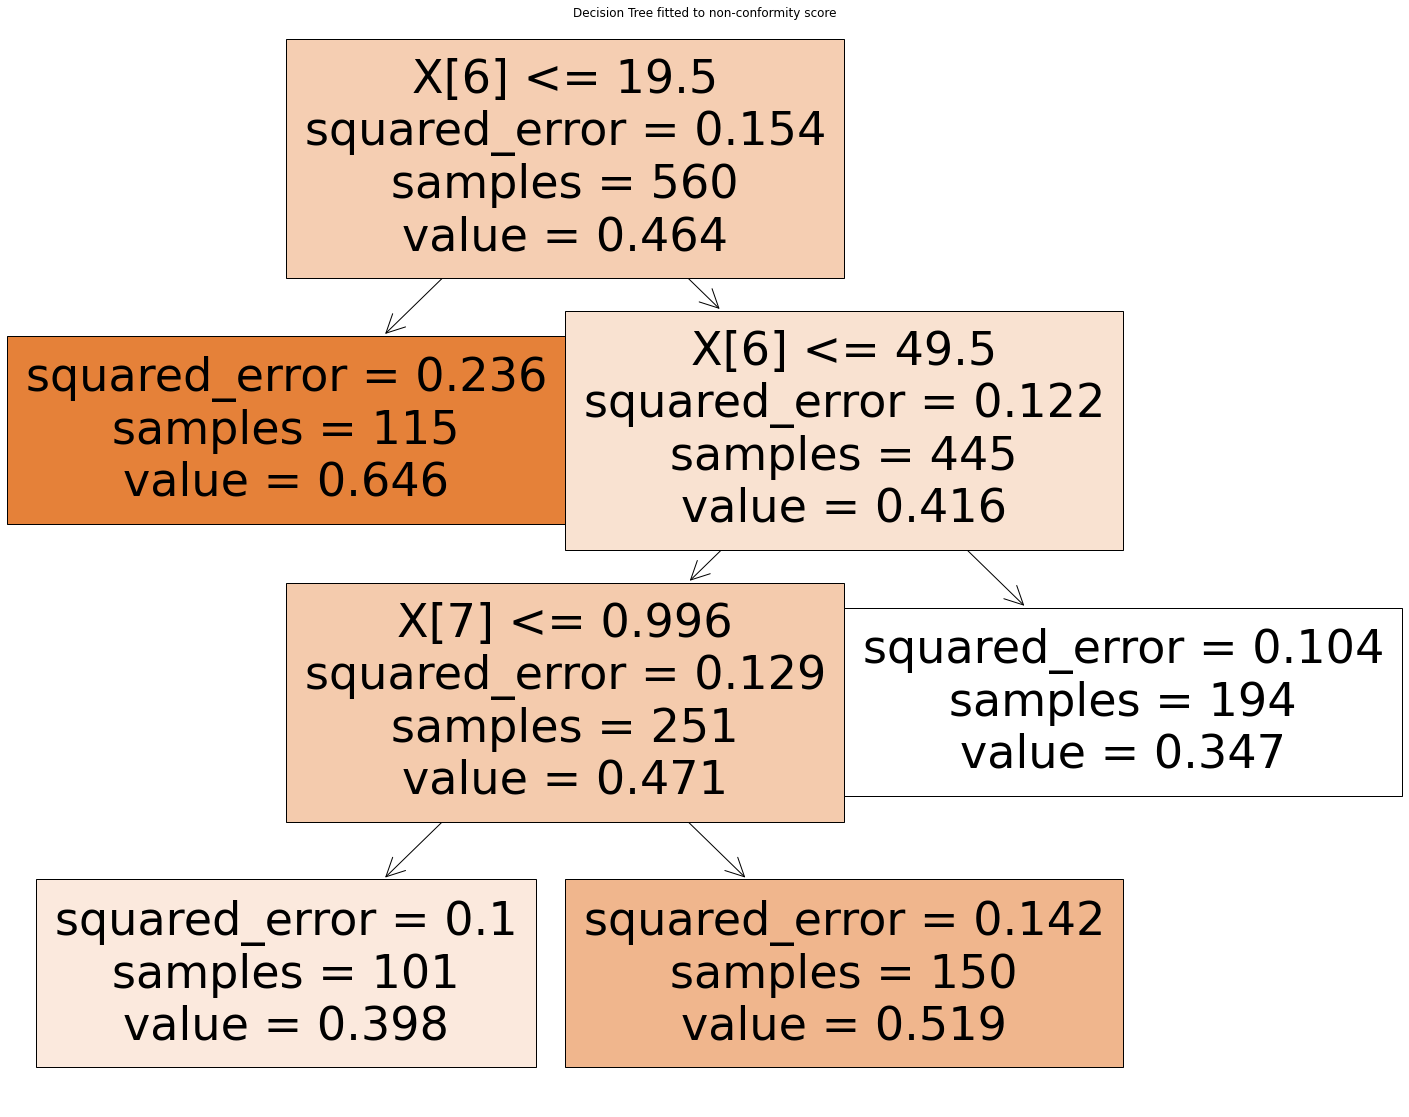

<Figure size 432x288 with 0 Axes>

In [7]:
values_winered_nocalib = obtain_main_metrics(data_name = "winered",
test_size = 0.3,
calib_size = 0.5,
split_calib = False,
random_seed = 1250,
sig  = 0.1,
nbins = 10,
min_samples_leaf= 100,
figname_tree = "locart_tree_winered_nosplit.pdf",
random_state = 750)

In [8]:
values_winered_nocalib[0]

,Methods,Pearson correlation,HSIC correlation,delta wsc,delta_ils,Average marginal coverage,Average interval length,Average interval length given coverage
0,LOCLUSTER,-0.045741,3.493714e-06,0.016026,-0.014583,0.908333,2.023167,2.020696
1,LOCART,0.072082,3.838528e-05,0.038374,0.000000,0.877083,1.853315,1.862152
2,Regresion split,NaN,-1.163372e-30,0.004327,0.007900,0.881250,1.840000,1.840000
3,Weighted regression split,0.053656,9.713661e-05,0.050000,0.072917,0.950000,2.116050,2.128257
4,Mondrian regression split,0.059947,1.429368e-04,0.034978,-0.037186,0.877083,1.888550,1.899055


Testing for white wine data with splitting in calibration for locart:

Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  1.6268467903137207
Computing metrics
Time Elapsed to compute statistics for mondrian regression split:  7.3319432735443115
Fitting locluster
Time Elapsed to fit locluster:  4.486115217208862
Computing metrics
Time Elapsed to compute metrics for Locluster:  21.116355180740356
Fitting locart
Time Elapsed to fit Locart:  1.4697234630584717
Computing metrics
Time Elapsed to compute metrics for Locart:  19.049816370010376
Fitting regression split
Time Elapsed to fit regression split:  1.4022276401519775
Computing metrics
Time Elapsed to compute statistics for regression split:  7.143596172332764
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  1.9714772701263428
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  1.9714772701263428


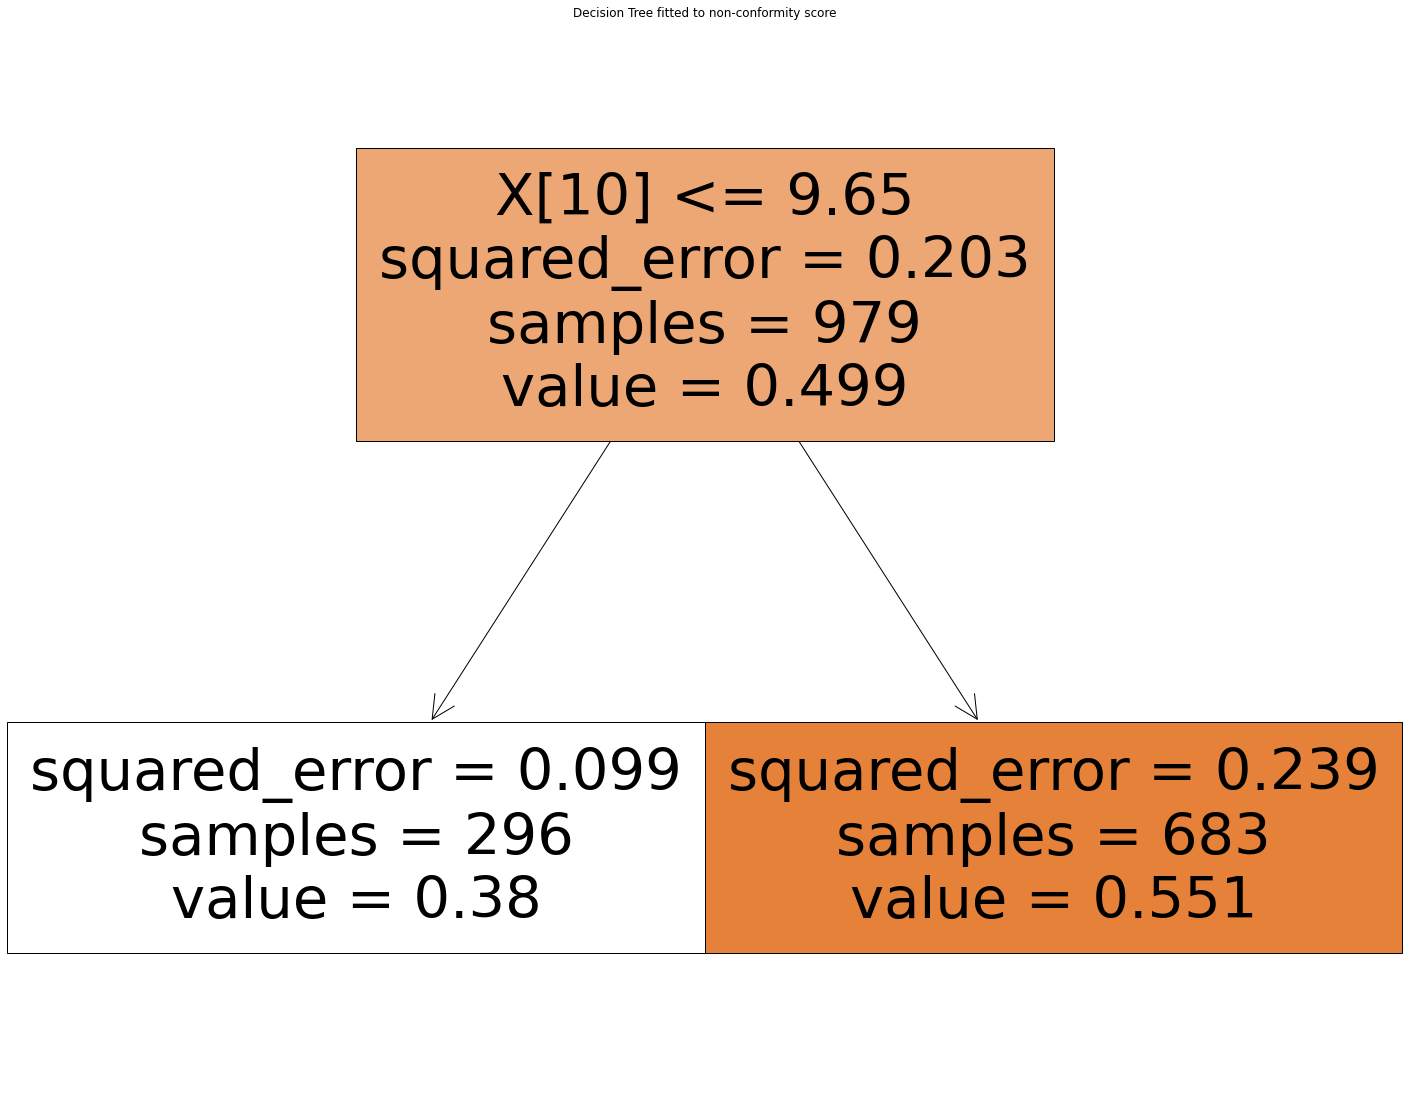

<Figure size 432x288 with 0 Axes>

In [9]:
values_winewhite = obtain_main_metrics(data_name = "winewhite",
test_size = 0.2,
calib_size = 0.5,
split_calib = True,
random_seed = 1250,
sig  = 0.1,
nbins = 10,
min_samples_leaf= 100,
figname_tree = "locart_tree_winewhite_split.pdf",
random_state = 750)

In [10]:
values_winewhite[0]

,Methods,Pearson correlation,HSIC correlation,delta wsc,delta_ils,Average marginal coverage,Average interval length,Average interval length given coverage
0,LOCLUSTER,-0.089575,4.397692e-05,0.022902,0.039885,0.895918,2.053020,2.044330
1,LOCART,-0.074620,3.303694e-05,0.035447,0.000000,0.898980,2.065124,2.057544
2,Regresion split,0.026871,-1.642104e-18,0.004762,-0.013572,0.900000,2.180000,2.180000
3,Weighted regression split,0.048369,5.381618e-05,0.042784,0.061224,0.950000,2.156815,2.168547
4,Mondrian regression split,-0.027843,2.932228e-05,0.037755,0.064390,0.894898,2.128857,2.124107


White wine without splitting:

Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  1.568995475769043
Computing metrics
Time Elapsed to compute statistics for mondrian regression split:  7.582372665405273
Fitting locluster
Time Elapsed to fit locluster:  5.2035911083221436
Computing metrics
Time Elapsed to compute metrics for Locluster:  25.58792734146118
Fitting locart
Time Elapsed to fit Locart:  1.5936379432678223
Computing metrics
Time Elapsed to compute metrics for Locart:  16.953601360321045
Fitting regression split
Time Elapsed to fit regression split:  1.1335721015930176
Computing metrics
Time Elapsed to compute statistics for regression split:  6.267871141433716
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  1.6435503959655762
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  1.6435503959655762


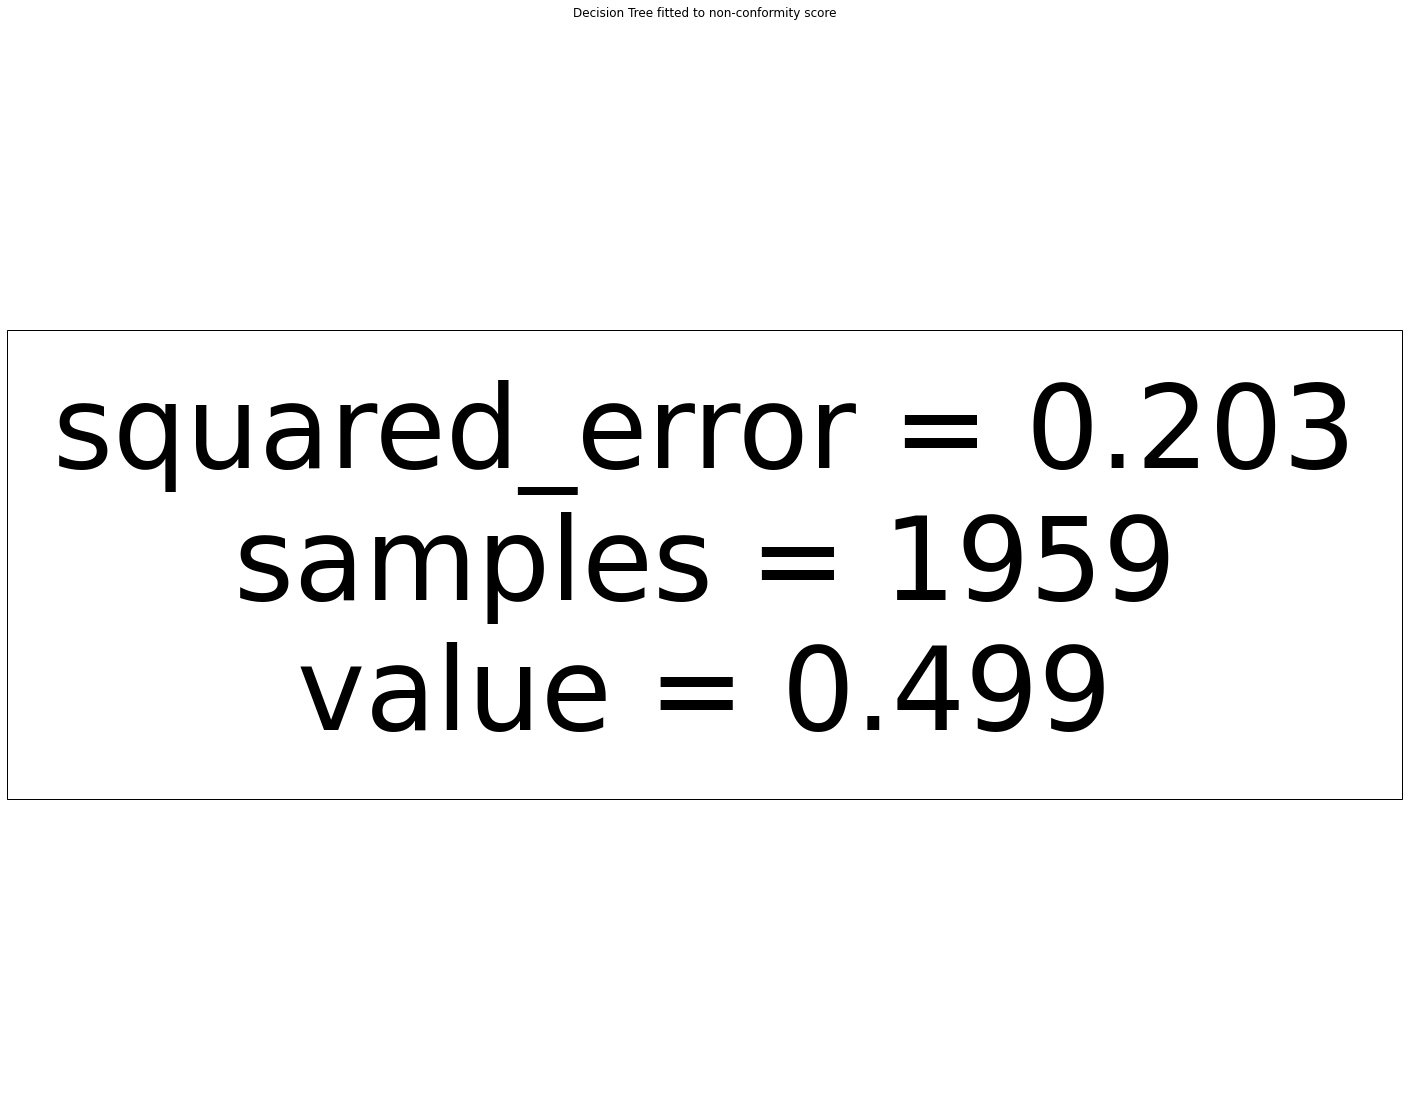

<Figure size 432x288 with 0 Axes>

In [11]:
values_winewhite_nocalib = obtain_main_metrics(data_name = "winewhite",
test_size = 0.2,
calib_size = 0.5,
split_calib = False,
random_seed = 1250,
sig  = 0.1,
nbins = 10,
min_samples_leaf= 100,
figname_tree = "locart_tree_winewhite_split.pdf",
random_state = 750)

In [12]:
values_winewhite_nocalib[0]

,Methods,Pearson correlation,HSIC correlation,delta wsc,delta_ils,Average marginal coverage,Average interval length,Average interval length given coverage
0,LOCLUSTER,-0.089575,4.397692e-05,0.022902,0.006980,0.895918,2.053020,2.044330
1,LOCART,-0.029980,4.828668e-10,0.006287,0.000000,0.896939,2.174808,2.174780
2,Regresion split,0.026871,-1.642104e-18,0.004762,0.003061,0.900000,2.180000,2.180000
3,Weighted regression split,0.048369,5.381618e-05,0.042784,0.073469,0.950000,2.156815,2.168547
4,Mondrian regression split,-0.027843,2.932228e-05,0.037755,0.007959,0.894898,2.128857,2.124107


Protein data:

In [13]:
values_protein = obtain_main_metrics(data_name = "protein",
test_size = 0.1,
calib_size = 0.5,
split_calib = True,
random_seed = 1250,
sig  = 0.1,
nbins = 20,
min_samples_leaf= 500,
figname_tree = "locart_tree_protein_split.pdf",
random_state = 750)

Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  28.268935918807983
Computing metrics


In [ ]:
values_protein[0]

,Methods,Pearson correlation,HSIC correlation,delta wsc,delta_ils,Average marginal coverage,Average interval length,Average interval length given coverage
0,LOCLUSTER,-0.010207,5.812485e-05,0.036523,0.038696,0.898644,11.932888,11.921946
1,LOCART,-0.003660,2.497355e-05,0.004258,0.000000,0.897551,12.126704,12.123535
2,Regresion split,-0.004983,4.400570e-20,0.027093,-0.087958,0.897551,12.916340,12.916340
3,Weighted regression split,0.029719,3.371315e-05,0.004059,0.082974,0.949923,11.160660,11.209683
4,Mondrian regression split,0.005210,8.018946e-06,0.027096,0.062101,0.899519,9.968858,9.978620


Locart without splitting calibration set for protein data:

Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  24.242719173431396
Computing metrics
Time Elapsed to compute statistics for mondrian regression split:  246.87769985198975
Fitting locluster
Time Elapsed to fit locluster:  58.093374252319336
Computing metrics
Time Elapsed to compute metrics for Locluster:  356.95967841148376
Fitting locart
Time Elapsed to fit Locart:  21.064882040023804
Computing metrics
Time Elapsed to compute metrics for Locart:  334.6387233734131
Fitting regression split
Time Elapsed to fit regression split:  23.25043797492981
Computing metrics
Time Elapsed to compute statistics for regression split:  243.59730339050293
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  28.385711193084717
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  28.385711193084717


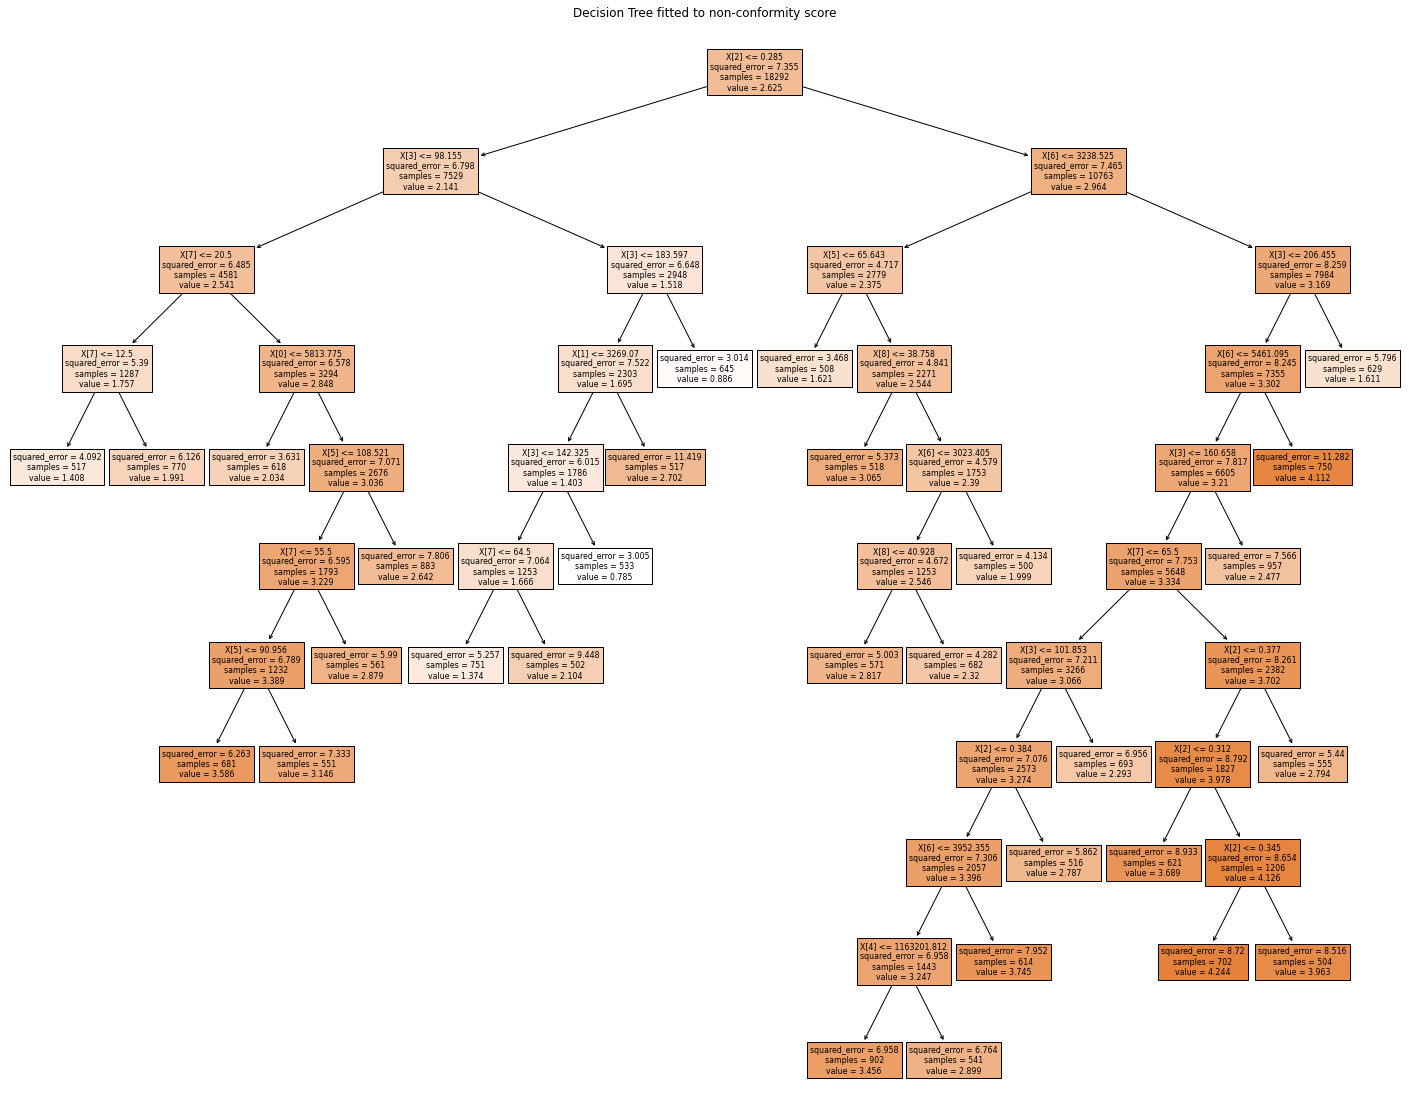

<Figure size 432x288 with 0 Axes>

In [ ]:
values_protein_nocalib = obtain_main_metrics(data_name = "protein",
test_size = 0.1,
calib_size = 0.5,
split_calib = False,
random_seed = 1250,
sig  = 0.1,
nbins = 20,
min_samples_leaf= 500,
figname_tree = "locart_tree_protein_split.pdf",
random_state = 750)

In [ ]:
values_protein_nocalib[0]

,Methods,Pearson correlation,HSIC correlation,delta wsc,delta_ils,Average marginal coverage,Average interval length,Average interval length given coverage
0,LOCLUSTER,-0.010207,5.812485e-05,0.036523,0.003750,0.898644,11.932888,11.921946
1,LOCART,0.023116,1.101965e-05,0.010015,0.000000,0.894161,11.865280,11.892099
2,Regresion split,-0.004983,4.400570e-20,0.027093,-0.123050,0.897551,12.916340,12.916340
3,Weighted regression split,0.029719,3.371315e-05,0.004059,0.087456,0.949923,11.160660,11.209683
4,Mondrian regression split,0.005210,8.018946e-06,0.027096,0.055500,0.899519,9.968858,9.978620


Cycle data with splitting:

Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  1.799633264541626
Computing metrics
Time Elapsed to compute statistics for mondrian regression split:  14.998045206069946
Fitting locluster
Time Elapsed to fit locluster:  4.972681760787964
Computing metrics
Time Elapsed to compute metrics for Locluster:  39.34873628616333
Fitting locart
Time Elapsed to fit Locart:  1.3364224433898926
Computing metrics
Time Elapsed to compute metrics for Locart:  39.41783833503723
Fitting regression split
Time Elapsed to fit regression split:  1.547994613647461
Computing metrics
Time Elapsed to compute statistics for regression split:  22.099184274673462
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  2.1518566608428955
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  2.1518566608428955


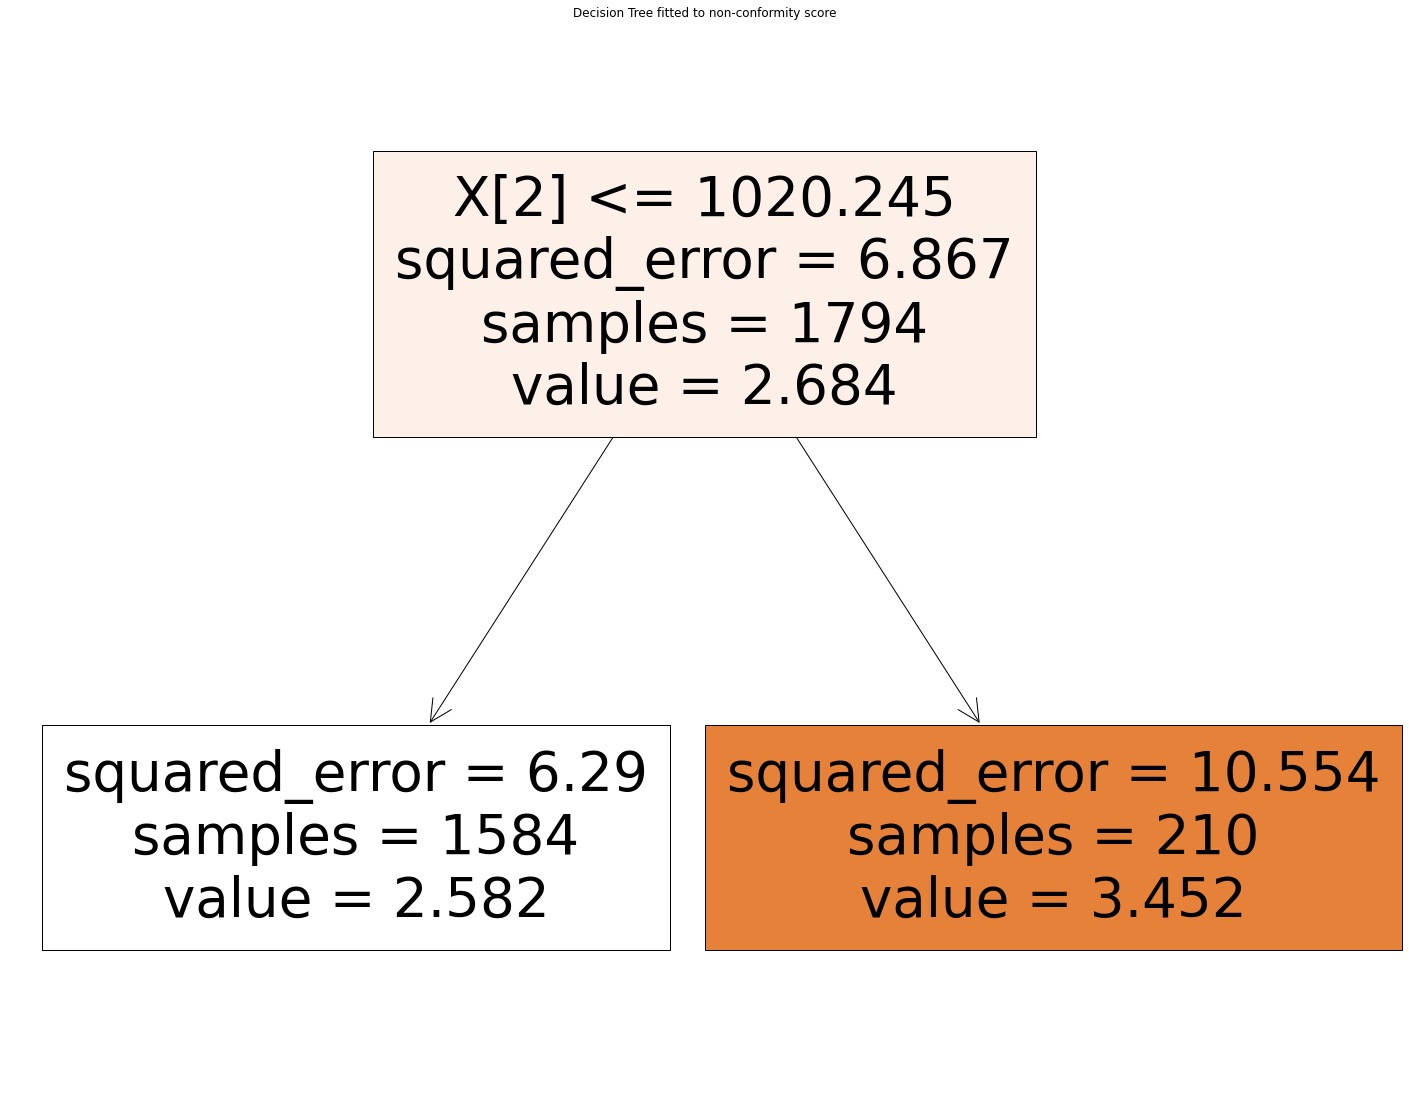

<Figure size 432x288 with 0 Axes>

In [ ]:
values_cycle = obtain_main_metrics(data_name = "cycle",
test_size = 0.15,
calib_size = 0.5,
split_calib = True,
random_seed = 1250,
sig  = 0.1,
nbins = 10,
min_samples_leaf= 100,
figname_tree = "locart_tree_cycle_split.pdf",
random_state = 750)

In [ ]:
values_cycle[0]

,Methods,Pearson correlation,HSIC correlation,delta wsc,delta_ils,Average marginal coverage,Average interval length,Average interval length given coverage
0,LOCLUSTER,2.616218e-02,1.805863e-05,0.002717,0.028085,0.920987,11.944761,11.955436
1,LOCART,1.026431e-02,1.331310e-06,0.017455,0.000000,0.914716,11.804669,11.806789
2,Regresion split,-5.331704e-16,2.543356e-19,0.035655,-0.053342,0.905518,11.577600,11.577600
3,Weighted regression split,5.793429e-02,4.426574e-05,0.009407,0.064284,0.949833,11.029927,11.100993
4,Mondrian regression split,6.575564e-02,5.935879e-05,0.010750,0.023374,0.906355,11.257004,11.318854


Cycle without splitting:

In [ ]:
values_cycle_nocalib = obtain_main_metrics(data_name = "cycle",
test_size = 0.15,
calib_size = 0.5,
split_calib = False,
random_seed = 1250,
sig  = 0.1,
nbins = 10,
min_samples_leaf= 100,
figname_tree = "locart_tree_cycle_nosplit.pdf",
random_state = 750)

Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  1.6008551120758057
Computing metrics
Time Elapsed to compute statistics for mondrian regression split:  15.23102593421936
Fitting locluster


ValueError: Found input variables with inconsistent numbers of samples: [1913, 1914]

In [ ]:
values_cycle_nocalib[0]

,Methods,Pearson correlation,HSIC correlation,delta wsc,delta_ils,Average marginal coverage,Average interval length,Average interval length given coverage
0,LOCLUSTER,2.616218e-02,1.805863e-05,0.002717,-0.020629,0.920987,11.944761,11.955436
1,LOCART,1.241661e-02,1.826625e-06,0.018870,0.000000,0.909281,11.510520,11.513814
2,Regresion split,-5.331704e-16,2.543356e-19,0.035655,-0.000473,0.905518,11.577600,11.577600
3,Weighted regression split,5.793429e-02,4.426574e-05,0.009407,0.073885,0.949833,11.029927,11.100993
4,Mondrian regression split,8.385941e-02,6.870652e-05,0.015921,-0.007004,0.907609,11.236297,11.322247


Electric with splitting:

In [ ]:
values_electric = obtain_main_metrics(data_name = "electric",
test_size = 0.1,
calib_size = 0.5,
split_calib = True,
random_seed = 1250,
sig  = 0.1,
nbins = 10,
min_samples_leaf= 500,
figname_tree = "locart_tree_electric_split.pdf",
random_state = 750)

NameError: name 'obtain_main_metrics' is not defined

In [ ]:
values_electric[0]

,Methods,Pearson correlation,HSIC correlation,delta wsc,delta_ils,Average marginal coverage,Average interval length,Average interval length given coverage
0,LOCLUSTER,0.048715,1.748898e-08,0.080667,0.055135,0.864,0.037742,0.037914
1,LOCART,0.045247,5.581265e-09,0.031730,0.000000,0.873,0.037810,0.037906
2,Regresion split,-0.011096,1.431849e-20,0.009789,-0.045121,0.906,0.041065,0.041065
3,Weighted regression split,0.035917,1.483627e-08,0.041837,0.107000,0.950,0.041684,0.041829
4,Mondrian regression split,0.028151,4.419846e-09,0.022667,0.058243,0.894,0.039874,0.039957


Electric without splitting:

Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  6.328906774520874
Computing metrics
Time Elapsed to compute statistics for mondrian regression split:  9.417043685913086
Fitting locluster
Time Elapsed to fit locluster:  13.960992574691772
Computing metrics
Time Elapsed to compute metrics for Locluster:  25.563150644302368
Fitting locart
Time Elapsed to fit Locart:  5.665615081787109
Computing metrics
Time Elapsed to compute metrics for Locart:  23.611494302749634
Fitting regression split
Time Elapsed to fit regression split:  5.537187576293945
Computing metrics
Time Elapsed to compute statistics for regression split:  9.276042938232422
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  6.391786813735962
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  6.391786813735962


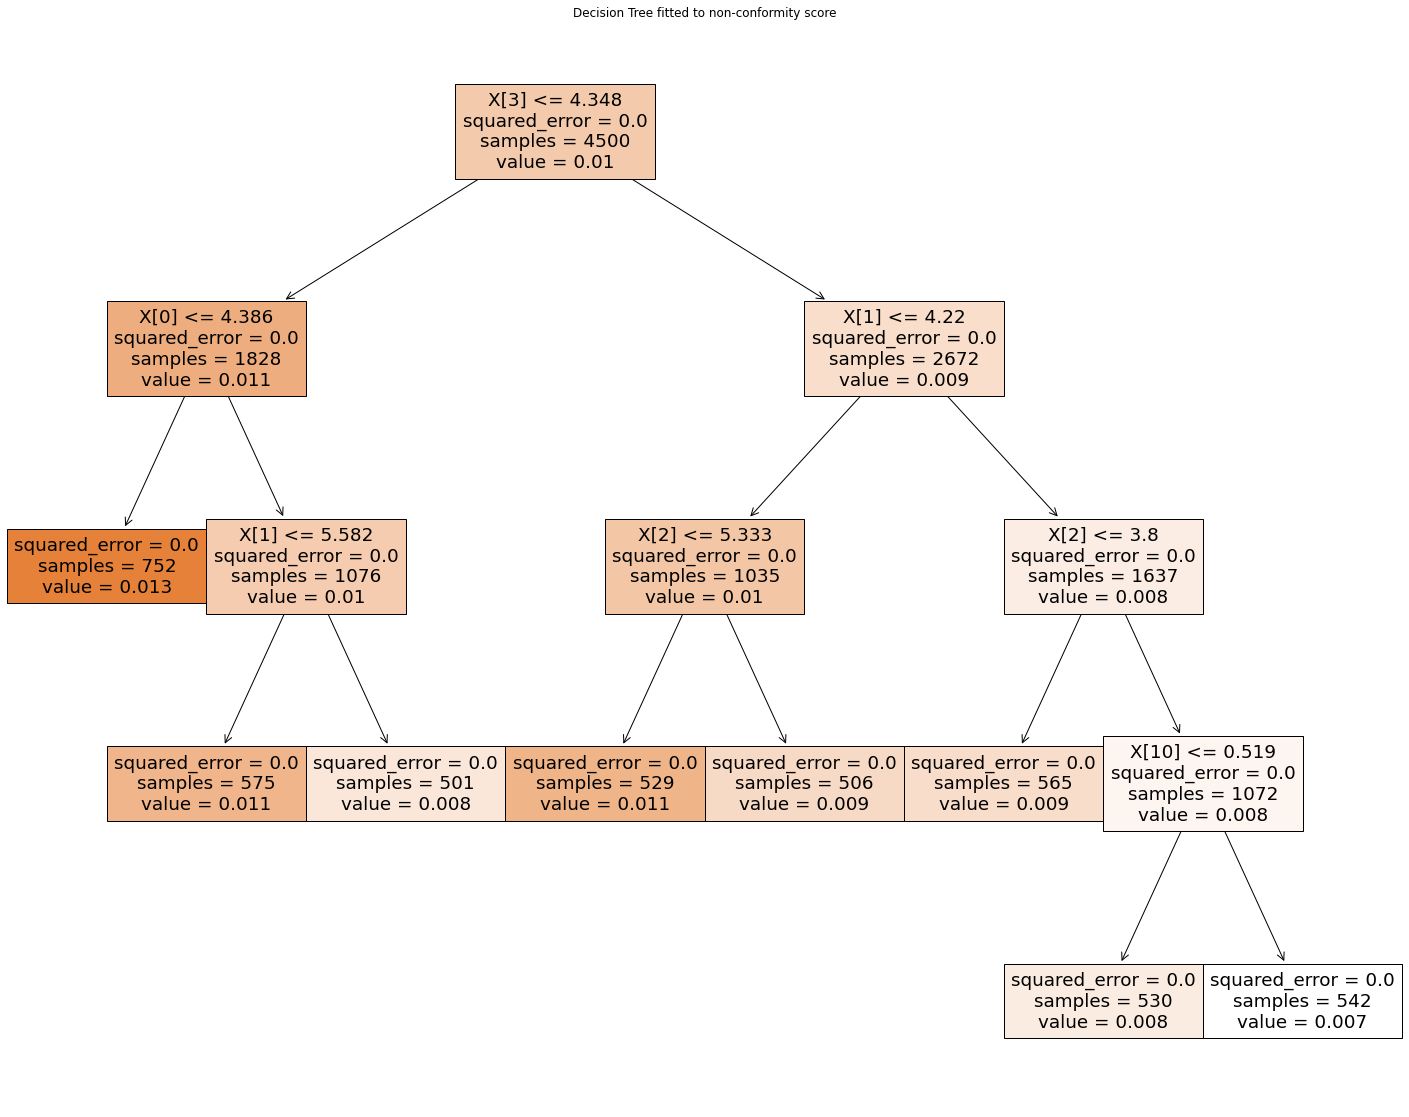

<Figure size 432x288 with 0 Axes>

In [ ]:
values_electric_nocalib = obtain_main_metrics(data_name = "electric",
test_size = 0.1,
calib_size = 0.5,
split_calib = False,
random_seed = 1250,
sig  = 0.1,
nbins = 10,
min_samples_leaf= 100,
figname_tree = "locart_tree_electric_nosplit.pdf",
random_state = 750)

In [ ]:
values_electric_nocalib[0]

,Methods,Pearson correlation,HSIC correlation,delta wsc,delta_ils,Average marginal coverage,Average interval length,Average interval length given coverage
0,LOCLUSTER,0.048715,1.748898e-08,0.080667,0.025333,0.864,0.037742,0.037914
1,LOCART,0.110657,1.144685e-07,0.041183,0.000000,0.844,0.036395,0.036847
2,Regresion split,-0.011096,1.431849e-20,0.009789,-0.045775,0.906,0.041065,0.041065
3,Weighted regression split,0.035917,1.483627e-08,0.041837,0.096000,0.950,0.041684,0.041829
4,Mondrian regression split,0.028151,4.419846e-09,0.022667,0.105137,0.894,0.039874,0.039957


News with split:

In [ ]:
values_news = obtain_main_metrics(data_name = "news",
test_size = 0.1,
calib_size = 0.5,
split_calib = True,
random_seed = 1250,
sig  = 0.1,
nbins = 10,
min_samples_leaf= 500,
figname_tree = "locart_tree_news_split.pdf",
random_state = 750)

In [ ]:
values_news[0]

News without split:

In [ ]:
values_news_nocalib = obtain_main_metrics(data_name = "news",
test_size = 0.1,
calib_size = 0.5,
split_calib = False,
random_seed = 1250,
sig  = 0.1,
nbins = 10,
min_samples_leaf= 500,
figname_tree = "locart_tree_news_nosplit.pdf",
random_state = 750)

In [ ]:
values_news_nocalib[0]

Superconductivity with split:

In [ ]:
values_superconduct = obtain_main_metrics(data_name = "superconductivity",
test_size = 0.1,
calib_size = 0.5,
split_calib = True,
random_seed = 1250,
sig  = 0.1,
nbins = 10,
min_samples_leaf= 250,
figname_tree = "locart_tree_superconduct_split.pdf",
random_state = 750)

In [ ]:
values_superconduct[0]

Superconductivity without split:

In [ ]:
values_superconduct_nocalib = obtain_main_metrics(data_name = "superconductivity",
test_size = 0.1,
calib_size = 0.5,
split_calib = False,
random_seed = 1250,
sig  = 0.1,
nbins = 10,
min_samples_leaf= 250,
figname_tree = "locart_tree_superconduct_nosplit.pdf",
random_state = 750)

In [ ]:
values_superconduct_nocalib[0]